In [1]:
%env CXX=/home/adr/micromamba/envs/dev/bin/g++

env: CXX=/home/adr/micromamba/envs/dev/bin/g++


In [2]:
!/home/adr/micromamba/envs/dev/bin/g++ --version

g++ (conda-forge gcc 12.3.0-0) 12.3.0
Copyright (C) 2022 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
import nutpie
import pathlib
import arviz
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import posteriordb
import json
import cmdstanpy
import time
import fastprogress
import pandas as pd
import xarray as xr
import os
import bridgestan

In [4]:
nutpie.__version__

'0.8.0'

In [5]:
bridgestan.__version__

'2.1.2'

In [6]:
cmdstanpy.__version__

'1.1.0'

In [7]:
# This is the version of the python wrapper
posteriordb.__version__

'0.2.0'

In [8]:
db_path = "../../posteriordb/posterior_database/"
db = posteriordb.PosteriorDatabase(db_path)

In [9]:
# The version of the posteriordb itself (one commit after 0.4)
!git -C "{db_path}" rev-parse HEAD

8bc65e69f7304d6f69023ba59ef9c5a04a1074fd


In [10]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

In [11]:
# Install cmdstan if necessary...
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.32.2
Install directory: /home/adr/.cmdstan
CmdStan version 2.32.2 already installed


True

In [12]:
def store_trace(storage, name, kind, tr):
    tr.to_netcdf(f"{storage}/{name}_{kind}.nc")
    ess = arviz.ess(tr)
    ess.to_netcdf(f"{storage}/{name}_{kind}_ess.nc")

In [13]:
def sample_nutpie(posterior, n_tunes, *, storage, n_chains=10, overwrite=True):
    with open(posterior.data.file_path()) as file:
        data = json.load(file)
    code = posterior.model.code("stan")

    start = time.time()
    compiled = nutpie.compile_stan_model(code=code).with_data(**posterior.data.values())
    end = time.time()
    time_compile = end - start

    for n_tune in n_tunes:
        start = time.time()
        tr = nutpie.sample(
            compiled,
            chains=n_chains,
            seed=1,
            progress_bar=False,
            draws=1000,
            tune=n_tune,
            cores=12,
            store_unconstrained=True,
            store_gradient=True,
        )
        end = time.time()
        tr.posterior.attrs["sampling_time"] = end - start
        tr.posterior.attrs["compile_time"] = time_compile
        store_trace(storage.format(n_tune=n_tune), posterior.name, "nutpie", tr)

def sample_stan(posterior, n_tunes, *, n_chains=10, storage, overwrite=True):
    start = time.time()
    cmd_model = cmdstanpy.CmdStanModel(posterior.model.name, posterior.model.code_file_path("stan"), compile=False)
    cmd_model.compile(force=True)
    end = time.time()
    time_compile = end - start
    with open(posterior.data.file_path()) as file:
        data = json.load(file)

    for n_tune in n_tunes:
        start = time.time()
        trace = cmd_model.sample(data, chains=n_chains, save_warmup=True,
                                 show_progress=False, seed=1, iter_warmup=n_tune, iter_sampling=1000)
        end = time.time()
        tr = arviz.from_cmdstanpy(trace, save_warmup=True)
        tr.posterior.attrs["sampling_time"] = end - start
        tr.posterior.attrs["compile_time"] = time_compile
        store_trace(storage.format(n_tune=n_tune), posterior.name, "stan", tr)

In [14]:
storage = "/mnt/harddrives/data_labs/covadapt-paper/2023-08-07-model-zoo_{n_tune}"

In [15]:
n_tunes = [300, 400, 600, 1000]

In [16]:
for n_tune in n_tunes:
    !mkdir -p {storage.format(n_tune=n_tune)}

In [17]:
names = db.posterior_names()

In [18]:
skip = [
    'ecdc0401-covid19imperial_v2',
    'ecdc0401-covid19imperial_v3',
    'ecdc0501-covid19imperial_v2',
    'ecdc0501-covid19imperial_v3',
    'election88-election88_full',
    'hmm_gaussian_simulated-hmm_gaussian',
    'iohmm_reg_simulated-iohmm_reg',
    'mnist-nn_rbm1bJ100',
    'mnist_100-nn_rbm1bJ10',
    'prideprejudice_chapter-ldaK5',
    'prideprejudice_paragraph-ldaK5',
    'prostate-logistic_regression_rhs',
]

In [ ]:
traces_nutpie = []
traces_stan = []

ess_nutpie = []
ess_stan = []

times_nutpie = []
times_stan = []

model_names = []
failed_models = []
errors = []

for i, name in enumerate(fastprogress.progress_bar(names)):
    if name in skip:
        continue

    try:
        sample_nutpie(db.posterior(name), n_tunes, storage=storage, overwrite=True)
    except (ValueError, RuntimeError, IndexError) as error:
        errors.append(("nutpie", error))
        print(name)
        print(errors[-1])
        failed_models.append(("nutpie", name))
    try:
        sample_stan(db.posterior(name), n_tunes, storage=storage, overwrite=True)
    except (ValueError, RuntimeError, IndexError) as error:
        errors.append(("stan", error))
        print(name)
        print(errors[-1])
        failed_models.append(("stan", name))

/home/adr/git/arviz/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


hudson_lynx_hare-lotka_volterra
('stan', RuntimeError("Error during sampling:\nException: integrate_ode_rk45: initial state[1] is inf, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 32, column 2 to line 35, column 42)\n\tException: integrate_ode_rk45: initial state[1] is inf, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 32, column 2 to line 35, column 42)\n\tException: lognormal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 44, column 4 to column 47)\n\tException: lognormal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 44, column 4 to column 47)\n\tException: lognormal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/home/adr/git/posteriordb/posterior_

arviz - WARNING - Array contains NaN-value.


sir-sir
('nutpie', ValueError("Sampling failed: Failed during evaluation: param_constrain() failed with exception: Exception: model_model_namespace::write_array: y[19][4] is -5.17146e-08, but must be greater than or equal to 0.000000 (in '/tmp/tmpp21cziwd/model.stan', line 52, column 2 to column 26)\n"))


In [ ]:
errors[0][1]

In [12]:
posterior = list(db.posteriors())[0]

In [13]:
cmd_model = cmdstanpy.CmdStanModel(posterior.model.name, posterior.model.code_file_path("stan"))

In [14]:
cmd_model.compile()

In [1]:
import bridgestan

In [ ]:
bridgestan.compile_model(

In [ ]:
cmd_model.sample(show_console=True)

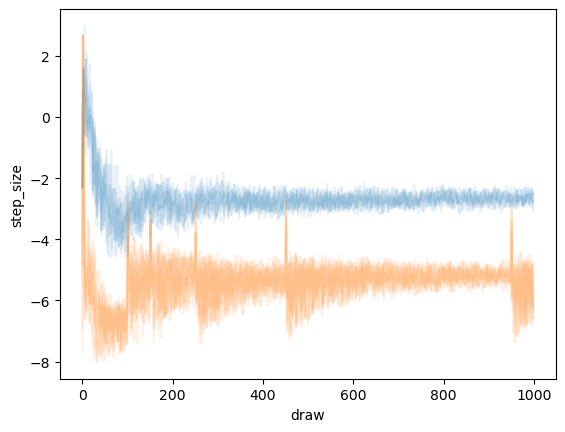

In [41]:
idx = 19
tr_nutpie = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_nutpie.nc")
tr_stan = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_stan.nc")

np.log(tr_nutpie.warmup_sample_stats.step_size).plot.line(x="draw", color="C0", alpha=0.1, add_legend=False)
np.log(tr_stan.warmup_sample_stats.step_size).plot.line(x="draw", color="C1", alpha=0.1, add_legend=False)


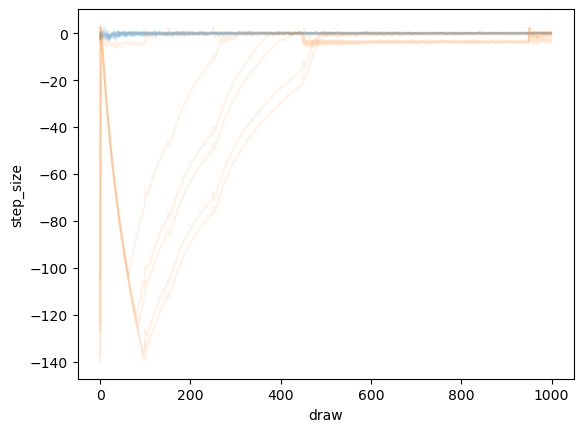

In [39]:
idx = 17
tr_nutpie = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_nutpie.nc")
tr_stan = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_stan.nc")

np.log(tr_nutpie.warmup_sample_stats.step_size).plot.line(x="draw", color="C0", alpha=0.1, add_legend=False)
np.log(tr_stan.warmup_sample_stats.step_size).plot.line(x="draw", color="C1", alpha=0.1, add_legend=False)


In [123]:
model_names.index("GLMM_Poisson_data-GLMM_Poisson_model")

0

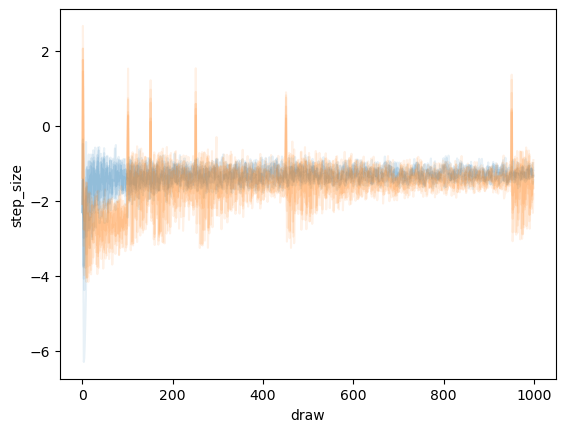

In [93]:
idx = 102
tr_nutpie = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_nutpie.nc")
tr_stan = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_stan.nc")

np.log(tr_nutpie.warmup_sample_stats.step_size).plot.line(x="draw", color="C0", alpha=0.1, add_legend=False)
np.log(tr_stan.warmup_sample_stats.step_size).plot.line(x="draw", color="C1", alpha=0.1, add_legend=False)


In [94]:
import arviz

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

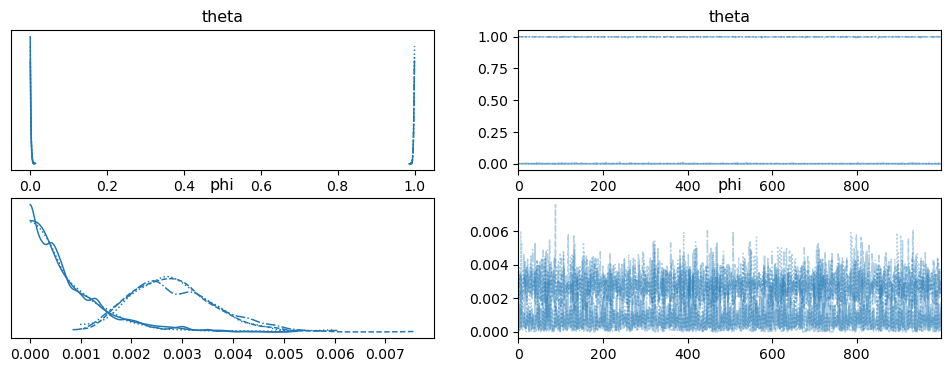

In [120]:
arviz.plot_trace(tr_nutpie.isel(theta_dim_0=0, theta_dim_1=0, phi_dim_1=0, phi_dim_0=0))

In [122]:
tr_nutpie.isel(theta_dim_0=0, theta_dim_1=0, phi_dim_1=0, phi_dim_0=0)

Inference data with groups:
	> posterior
	> sample_stats

Warmup iterations saved (warmup_*).

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

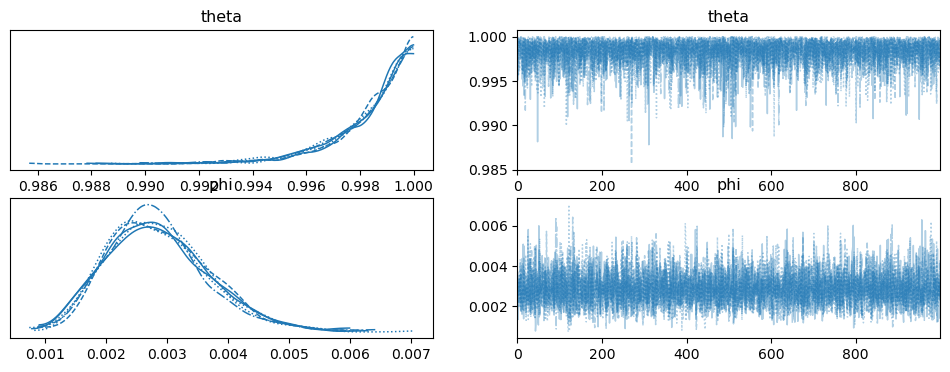

In [121]:
arviz.plot_trace(tr_stan.isel(theta_dim_0=0, theta_dim_1=0, phi_dim_1=0, phi_dim_0=0))

In [100]:
arviz.ess(tr_nutpie)

<xarray.Dataset>
Dimensions:      (theta_dim_0: 9, theta_dim_1: 2, phi_dim_0: 2, phi_dim_1: 249)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7 8
  * theta_dim_1  (theta_dim_1) int64 0 1
  * phi_dim_0    (phi_dim_0) int64 0 1
  * phi_dim_1    (phi_dim_1) int64 0 1 2 3 4 5 6 ... 242 243 244 245 246 247 248
Data variables:
    theta        (theta_dim_0, theta_dim_1) float64 9.358 9.315 ... 9.319 9.312
    phi          (phi_dim_0, phi_dim_1) float64 10.87 11.13 ... 9.319 9.295

In [101]:
arviz.ess(tr_stan)

<xarray.Dataset>
Dimensions:      (theta_dim_0: 9, theta_dim_1: 2, phi_dim_0: 2, phi_dim_1: 249)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7 8
  * theta_dim_1  (theta_dim_1) int64 0 1
  * phi_dim_0    (phi_dim_0) int64 0 1
  * phi_dim_1    (phi_dim_1) int64 0 1 2 3 4 5 6 ... 242 243 244 245 246 247 248
Data variables:
    theta        (theta_dim_0, theta_dim_1) float64 5.488e+03 ... 6.196e+03
    phi          (phi_dim_0, phi_dim_1) float64 6.969e+03 ... 8.224e+03

In [118]:
tr_stan.sample_stats.n_steps.values

array([[15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [31, 31, 31, ..., 31, 15, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [15, 15, 15, ..., 15, 15, 15]])

In [92]:
model_names.index("three_men3-ldaK2")

102

In [112]:
print(db.posterior("three_men3-ldaK2").model.code("stan"))

data {
  int<lower=2> V;               // num words
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
}
transformed data {
  int<lower=1> K = 2;
  vector<lower=0>[K] alpha; // topic prior
  vector<lower=0>[V] beta; // word prior
  for (k in 1:K)
    alpha[k] = 1;
  for (v in 1:V)
    beta[v] = 1;
}
parameters {
  simplex[K] theta[M];   // topic dist for doc m
  simplex[V] phi[K];     // word dist for topic k
}
model {
  for (m in 1:M)
    theta[m] ~ dirichlet(alpha);  // prior
  for (k in 1:K)
    phi[k] ~ dirichlet(beta);     // prior
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K)
      gamma[k] = log(theta[doc[n], k]) + log(phi[k, w[n]]);
    target += log_sum_exp(gamma);  // likelihood;
  }
}



In [7]:
model = db.posterior("ovarian-logistic_regression_rhs")
code = model.model.code("stan")
compiled = nutpie.compile_stan_model(code=code).with_data(**model.data.values())

In [8]:
trace = nutpie.sample(compiled, store_gradient=True, seed=1, store_mass_matrix=True, tune=2000)

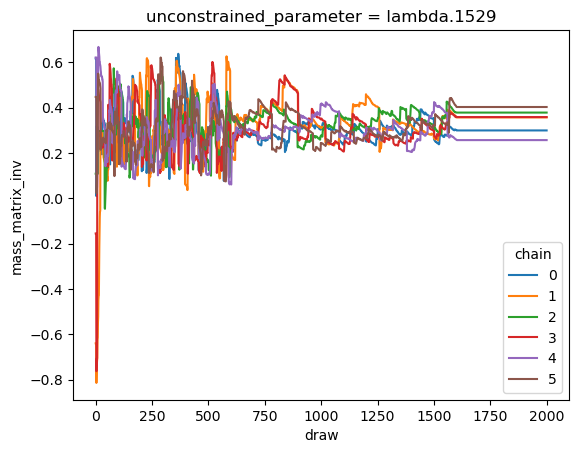

In [9]:
np.log10(trace.warmup_sample_stats.mass_matrix_inv).isel(unconstrained_parameter=-9).plot.line(x="draw")

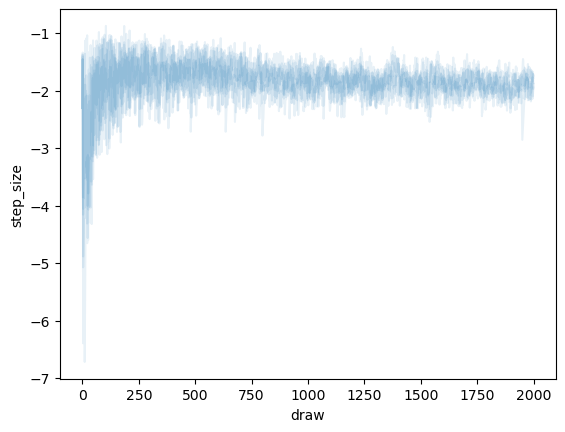

In [38]:
np.log(trace.warmup_sample_stats.step_size).plot.line(x="draw", color="C0", alpha=0.1, add_legend=False)

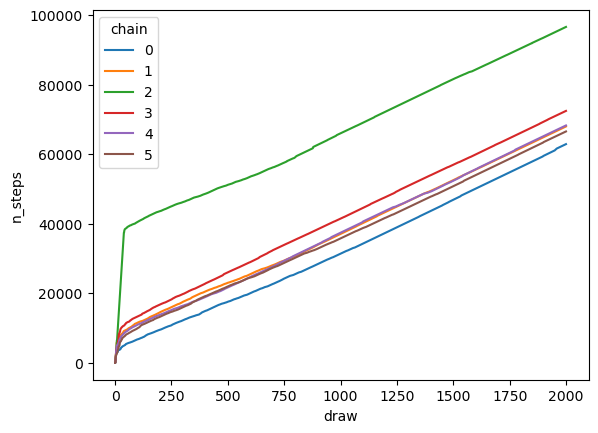

In [40]:
trace.warmup_sample_stats.n_steps.cumsum("draw").plot.line(x="draw")

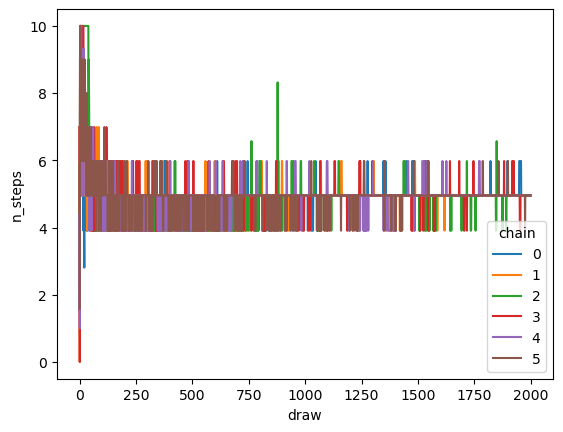

In [39]:
np.log2(trace.warmup_sample_stats.n_steps).plot.line(x="draw")

In [168]:
trace.warmup_sample_stats.sel(chain=1)

<xarray.Dataset>
Dimensions:                  (draw: 1000, unconstrained_parameter: 45)
Coordinates:
    chain                    int64 1
  * draw                     (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * unconstrained_parameter  (unconstrained_parameter) object 'alpha' ... 'si...
Data variables: (12/13)
    depth                    (draw) uint64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    maxdepth_reached         (draw) bool False False False ... False False False
    index_in_trajectory      (draw) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    logp                     (draw) float64 -inf -inf -inf ... -inf -inf -inf
    energy                   (draw) float64 inf inf inf inf ... inf inf inf inf
    diverging                (draw) bool True True True True ... True True True
    ...                       ...
    step_size_bar            (draw) float64 0.1 0.2335 ... 2.672e-199 2.092e-199
    mean_tree_accept         (draw) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    n_steps                  (draw) uint64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    mass_matrix_inv          (draw, unconstrained_parameter) float64 1e-10 .....
    gradient                 (draw, unconstrained_parameter) float64 -6.416e+...
    unconstrained_draw       (draw, unconstrained_parameter) float64 nan ... nan
Attributes:
    created_at:     2023-07-05T02:22:41.146603
    arviz_version:  0.16.0.dev0

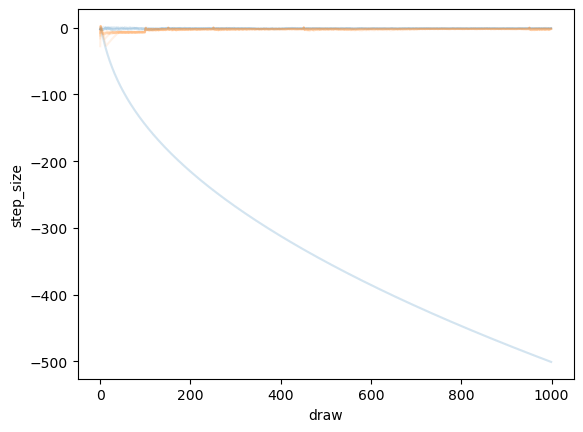

In [124]:
idx = 0
tr_nutpie = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_nutpie.nc")
tr_stan = arviz.from_netcdf(f"{storage.format(n_tune=1000)}/{model_names[idx]}_stan.nc")

np.log(tr_nutpie.warmup_sample_stats.step_size).plot.line(x="draw", color="C0", alpha=0.1, add_legend=False)
np.log(tr_stan.warmup_sample_stats.step_size).plot.line(x="draw", color="C1", alpha=0.1, add_legend=False)


In [128]:
arviz.ess(tr_nutpie)

<xarray.Dataset>
Dimensions:           (eps_dim_0: 40, log_lambda_dim_0: 40, lambda_dim_0: 40)
Coordinates:
  * eps_dim_0         (eps_dim_0) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
  * log_lambda_dim_0  (log_lambda_dim_0) int64 0 1 2 3 4 5 ... 34 35 36 37 38 39
  * lambda_dim_0      (lambda_dim_0) int64 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
Data variables:
    alpha             float64 7.536
    beta1             float64 9.096
    beta2             float64 8.819
    beta3             float64 7.628
    eps               (eps_dim_0) float64 7.673 9.032 7.676 ... 9.545 9.049
    sigma             float64 7.997
    log_lambda        (log_lambda_dim_0) float64 8.82 8.868 ... 8.982 9.003
    lambda            (lambda_dim_0) float64 8.82 8.868 8.871 ... 8.982 9.003

In [129]:
arviz.ess(tr_stan)

<xarray.Dataset>
Dimensions:           (eps_dim_0: 40, log_lambda_dim_0: 40, lambda_dim_0: 40)
Coordinates:
  * eps_dim_0         (eps_dim_0) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
  * log_lambda_dim_0  (log_lambda_dim_0) int64 0 1 2 3 4 5 ... 34 35 36 37 38 39
  * lambda_dim_0      (lambda_dim_0) int64 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
Data variables:
    alpha             float64 1.91e+03
    beta1             float64 1.075e+03
    beta2             float64 2.14e+03
    beta3             float64 1.506e+03
    eps               (eps_dim_0) float64 3.579e+03 7.872e+03 ... 2.289e+03
    sigma             float64 43.24
    log_lambda        (log_lambda_dim_0) float64 2.584e+03 ... 2.844e+03
    lambda            (lambda_dim_0) float64 2.584e+03 3.019e+03 ... 2.843e+03

/home/adr/git/arviz/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/adr/git/arviz/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/adr/git/arviz/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/adr/git/arviz/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/adr/git/arviz/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to ha

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'log_lambda'}>,
        <Axes: title={'center': 'log_lambda'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>]], dtype=object)

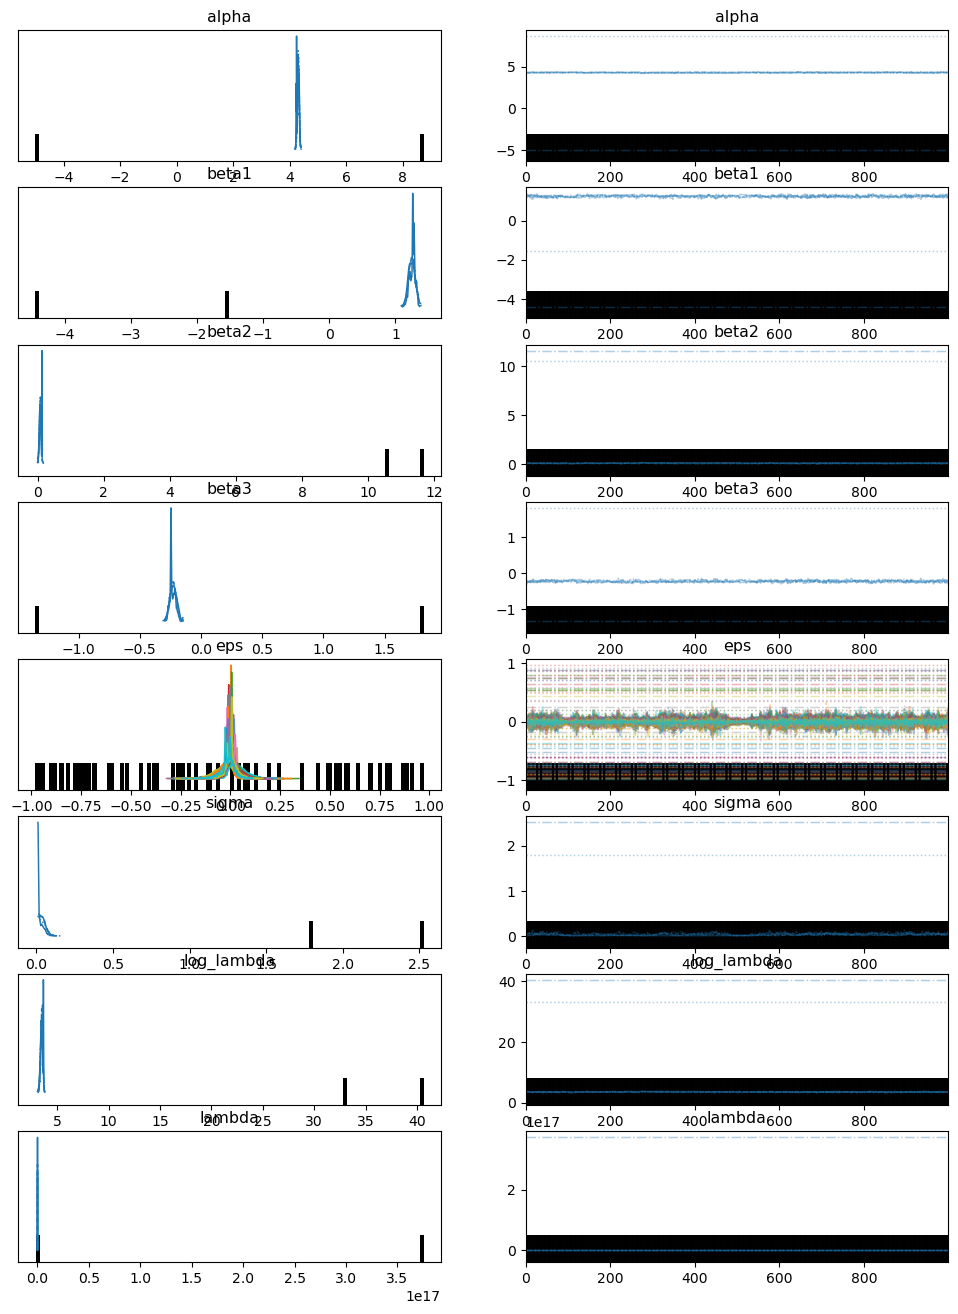

In [127]:
arviz.plot_trace(tr_nutpie.isel(log_lambda_dim_0=0, lambda_dim_0=0))